In [6]:
import numpy as np
import pandas as pd
import pygmo as pg
from base_gg_cycle import GasGeneratorCycle
from base_ep_cycle import ElectricPumpCycle
import matplotlib.pyplot as plt

base_arguments = {
    'thrust': 75E3, 'burn_time': 1200, 'combustion_chamber_pressure': 7.0E6, 'oxidizer_name': 'LO2_NASA',
    'fuel_name': 'RP1_NASA', 'is_frozen': True, 'exit_pressure': .002E6, 'max_acceleration': 4.5,
    'heat_ratio_pressurant': 1.667, 'mass_mixture_ratio': 2.45, 'pressurant_initial_pressure': 27E6,
    'pressurant_final_pressure': 5E6,
    'oxidizer_initial_pressure': .4E6, 'fuel_initial_pressure': .25E6, 'fuel_pump_pressure_factor': 1.55,
    'oxidizer_pump_pressure_factor': 1.15, 'pressurant_gas_constant': 2080,
    'pressurant_initial_temperature': 100, 'oxidizer_pump_efficiency': .66, 'fuel_pump_efficiency': .61,
    'pressurant_margin_factor': 1.1, 'pressurant_tank_structural_factor': 1.2,
    'propellant_margin_factor': 1.01, 'tanks_structural_factor': 2.5, 'ullage_volume_factor': 1.08,
    'oxidizer_density': 1126.1, 'fuel_density': 804.2, 'tanks_material_density': 2850,
    'pressurant_tank_material_density': 4430, 'tanks_yield_strength': 250E6,
    'pressurant_tank_yield_strength': 1100E6, 'verbose': True, 'kwak_fix': False
}

gg_arguments = {
    'gg_gas_specific_heat': 2024.7, 'heat_ratio_gg_gas': 1.16, 'mass_mixture_ratio_gg': 0.320,
    'turbine_pressure_ratio': 27, 'gas_constant_gg_gas': 274.1, 'turbine_inlet_temperature': 900,
    'gas_generator_stay_time': 10E-3, 'turbopump_specific_power': 13.5E3, 'turbine_efficiency': .52,
    'gg_structural_factor': 2.5, 'gg_material_density': 8220, 'gg_yield_strength': 550E6, 'gg_thrust_contribution': 0.01

}

ep_arguments = {
    'fuel_pump_specific_power': 15E3, 'oxidizer_pump_specific_power': 20E3, 'fuel_specific_heat': 2009,
    'electric_motor_specific_power': 5.3E3, 'inverter_specific_power': 60E3, 'battery_specific_power': 6.95E3,
    'battery_specific_energy': 198 * 3600, 'electric_motor_efficiency': .95, 'inverter_efficiency': .85,
    'battery_structural_factor': 1.2, 'coolant_allowable_temperature_change': 40,
}


class EngineCycleOptimization:
    def __init__(self, cycle=ElectricPumpCycle, arguments=base_arguments):
        if cycle == ElectricPumpCycle:
            extra_arguments = ep_arguments
        elif cycle == GasGeneratorCycle:
            extra_arguments = gg_arguments
        self.ec = cycle(**arguments, **extra_arguments)

    def fitness(self, x):
        self.ec.mmr = x[0]
        self.ec.p_cc = x[1]
        return [self.ec.mass]

    def get_bounds(self):
        return [1.5, 1E6], [4, 3E7]

method = 'Nelder-Mead'
n_pop = 1
burn_range = np.linspace(300, 1200, 20)
base_arguments['kwak_fix'] = True
data = []
for is_frozen in [True, False]:
    base_arguments['is_frozen'] = is_frozen
    for cycle in [GasGeneratorCycle, ElectricPumpCycle]:
        mmr_data = []
        p_cc_data = []
        for burn_time in burn_range:
            base_arguments['burn_time'] = burn_time
            prob = pg.problem(EngineCycleOptimization(cycle=cycle, arguments=base_arguments))
            algo = pg.algorithm(pg.scipy_optimize(method=method))
            pop = pg.population(prob, n_pop)
            pop = algo.evolve(pop)
            mmr_opt, p_cc_opt = pop.champion_x
            mmr_data.append(mmr_opt)
            p_cc_data.append(p_cc_opt * 1E-6)
        mode = 'Frozen' if is_frozen else 'Shifting'
        cycle_name, color = ('EP', "blue") if cycle == ElectricPumpCycle else ('GG', 'red')
        linestyle = 'solid' if is_frozen else 'dashed'
        label = f'{cycle_name}_{mode.lower()}'
        data.append([p_cc_data, mmr_data, mode, cycle_name, color, linestyle, label])
        print(f'data made for {label}')
data

data made for GG_frozen
data made for EP_frozen
data made for GG_shifting
data made for EP_shifting


[[[30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0,
   30.0],
  [2.5441663544272943,
   2.5433737699091017,
   2.5428023071866575,
   2.542326057851884,
   2.5419432741965617,
   2.5416543709729114,
   2.541388339679693,
   2.541225800236712,
   2.5410534018212374,
   2.5408335928240415,
   2.5407097446181384,
   2.5405555234745107,
   2.540454426475653,
   2.540383177540167,
   2.540301657564747,
   2.5402276786484035,
   2.5400765762814723,
   2.5400613050376935,
   2.5399630506392823,
   2.53992778414264],
  'Frozen',
  'GG',
  'red',
  'solid',
  'GG_frozen'],
 [[6.212998239014709,
   6.477356459036452,
   6.700149649789296,
   6.893383091048326,
   7.062654924235534,
   7.214144235071617,
   7.34878040900509,
   7.469836219082254,
   7.579956065012194,
   7.681690113009162,
   7.773886803537197,
   7.859731953004747,
   7.939738501002695,
   8.01427033047477,
   8

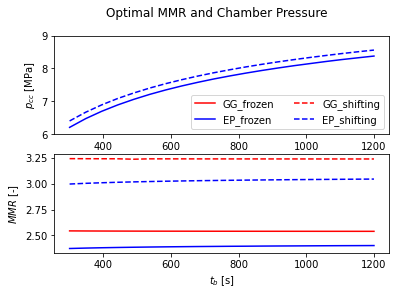

In [9]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Optimal MMR and Chamber Pressure')
ax1.set_ylabel('$p_{cc}$ [MPa]')
ax2.set_ylabel('$MMR$ [-]')
ax1.set_ylim(top=9, bottom=6)
plt.xlabel('$t_b$ [s]')
for p_cc_data, mmr_data, mode, cycle_name, color, linestyle, label in data:
    ax1.plot(burn_range, p_cc_data, label=label, color=color, linestyle=linestyle)
    ax2.plot(burn_range, mmr_data, label=label, color=color, linestyle=linestyle)
ax1.legend(ncol=2, loc=0)
plt.savefig('data/opt_vals_kwak.png', dpi=600)